# Multi-channel spindles detection

This notebook demonstrates how to use YASA to perform **multi-channel sleep spindles detection** from a NumPy array (example 1) or a MNE Raw object (example 2). If you haven't done so already, check out the notebook on [single-channel spindles detection](02_spindles_detection_multi.ipynb).

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$.

## Example 1: Using a NumPy array

To illustrate the multi-channel spindles detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)
print(np.round(data[:, 0:5], 3))

(3, 2161058) ['Cz' 'Fz' 'Pz']
[[15.797 22.307 39.922 25.657 27.094]
 [16.896 26.385 40.966 21.833 24.456]
 [ 5.899 14.297 36.592 26.094 23.395]]


To apply the multi-channel detection, we use the [spindles_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html#yasa.spindles_detect) function:

In [2]:
# Apply the detection
sp = yasa.spindles_detect(data, sf, ch_names=chan, multi_only=False)

# Get the full detection dataframe
all_spindles = sp.summary()  
all_spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,522.54,522.78,523.79,1.25,45.509445,10.850299,2.131626,0.470228,13.082397,16.0,0.190476,Cz,0
1,585.51,586.09,586.38,0.87,59.435380,13.185339,2.255297,0.473192,12.945464,11.0,0.659091,Cz,0
2,598.06,598.62,599.54,1.48,79.922226,15.976502,2.373750,0.421111,12.889143,19.0,0.375839,Cz,0
3,604.36,604.73,605.12,0.76,60.648920,12.520378,2.210118,0.350348,12.645687,9.0,0.480519,Cz,0
4,607.53,607.98,608.05,0.52,50.211401,13.846638,2.357938,0.258203,13.449947,6.0,0.849057,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,20498.20,20498.74,20499.22,1.02,83.897639,19.548310,2.609572,0.515605,12.320190,12.0,0.524272,Pz,2
1913,20512.68,20512.95,20513.42,0.74,55.426790,11.739013,2.243399,0.355705,13.187207,10.0,0.360000,Pz,2
1914,20524.99,20525.30,20525.61,0.62,66.723038,17.171995,2.614124,0.302493,12.776808,7.0,0.492063,Pz,2
1915,20542.93,20543.36,20544.65,1.72,78.694386,14.282672,2.103757,0.287887,12.486788,20.0,0.248555,Pz,2


Using the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.summary) method, we can easily extract the number of spindles detected per channel, as well as the mean spindles properties per channel:

In [3]:
sp.summary(grp_chan=True, aggfunc='mean')

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,670,1.041463,78.698054,17.165940,2.428411,0.404349,12.655632,12.856716,0.519365
Fz,551,0.986261,70.968251,15.504383,2.328553,0.382090,12.483724,12.018149,0.516992
Pz,696,1.036351,70.985229,15.399090,2.326625,0.396186,12.663587,12.811782,0.513046


Since version 0.4.0 of YASA, it is possible to create an interactive plot of the detected spindles. For this, we need to enable the interactive mode of matplotlib (make sure you have installed and enabled [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/user_install.html)).

In [4]:
# %matplotlib widget
# sp.plot_detection();

Finally, we can also plot an average template of all detected spindles with the [plot_average](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.plot_average) method:

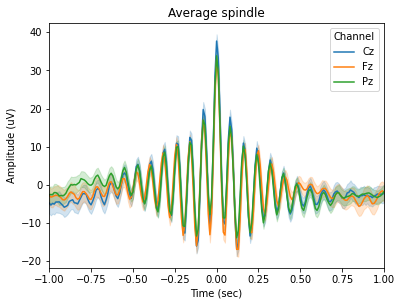

In [5]:
%matplotlib inline
sp.plot_average(center='Peak', time_before=1, time_after=1);

### Check the agreement between channels

Do the detected events overlap across channels? We can test this with the [compare_channels](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.compare_channels) method. In the example below, we calculate the [recall score](https://en.wikipedia.org/wiki/Precision_and_recall) between each pair of channels. To allow for slight variations in the onset of the spindle, we allow a tolerance of 0.5 seconds before and after the onset of each spindle.

In [6]:
sp.compare_channels(score="recall", max_distance_sec=0.5).round(3)

Channel,Cz,Fz,Pz
Channel,,,
Cz,1.000,0.643,0.743
Fz,0.782,1.000,0.655
Pz,0.716,0.519,1.000


In other words, 64.3% of the spindles detected on Cz were also detected on Fz. Conversely, 78.2% of the spindles detected on Fz were also detected on Cz. We can also use the [F1-score](https://en.wikipedia.org/wiki/F-score), which is order-independent (e.g. a symmetric matric).

In [7]:
sp.compare_channels(max_distance_sec=0.5).round(3)

Channel,Cz,Fz,Pz
Channel,,,
Cz,1.000,0.706,0.729
Fz,0.706,1.000,0.579
Pz,0.729,0.579,1.000


### Find spindles that are present on at least two channels

Using the `multi_only=True` argument, we force the detection to keep only the spindles that are present on at least two different channels. Spindles are considered the same if their start or end times fall within the same second. In other words, start and end times are rounded to the nearest integer and compared across channels.

In [8]:
sp_multi = yasa.spindles_detect(data, sf, ch_names=chan, multi_only=True, remove_outliers=True)
all_spindles = sp_multi.summary()
print(all_spindles.shape[0], 'spindles detected that are common to at least two electrodes.')
all_spindles.head().round(3)

1260 spindles detected that are common to at least two electrodes.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,585.51,586.09,586.38,0.87,59.435,13.185,2.255,0.473,12.945,11.0,0.659,Cz,0
1,598.06,598.62,599.54,1.48,79.922,15.977,2.374,0.421,12.889,19.0,0.376,Cz,0
2,604.36,604.73,605.12,0.76,60.649,12.520,2.210,0.350,12.646,9.0,0.481,Cz,0
3,655.06,655.50,655.88,0.82,47.596,10.832,2.149,0.369,13.297,11.0,0.530,Cz,0
4,725.60,726.50,726.88,1.28,77.591,18.836,2.371,0.288,12.368,15.0,0.698,Cz,0


In [9]:
sp_multi.summary(grp_chan=True)

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,486,1.031523,77.564127,16.878661,2.427572,0.408903,12.619925,12.705761,0.522530
Fz,356,0.954298,68.662420,15.007348,2.320736,0.384774,12.466655,11.629213,0.522715
Pz,418,1.056986,70.409223,15.256941,2.336045,0.409350,12.646223,13.100478,0.504384


### Compare two detections

What is the agreement between the regular detection and the detection after automatic outlier removal? To check this, we can use the [compare_detection](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.compare_detection) method, which will calculate the [precision, recall and F1-score](https://en.wikipedia.org/wiki/Precision_and_recall) of the two detections for each channel. Note that by default, the other detection is assumed to be the ground-truth. This method is also useful if you want to compare YASA detection against ground-truth human annotations. Here again, we can allow for slight variations in the onset of the spindle by defining a tolerance period before and after the onset of each spindle.

In [10]:
# Ground-truth is `sp_multi` (other)
sp.compare_detection(sp_multi, max_distance_sec=0.5)

,precision,recall,f1,n_self,n_other
Channel,,,,,
Cz,0.725373,1.0,0.840830,670,486
Fz,0.646098,1.0,0.785006,551,356
Pz,0.600575,1.0,0.750449,696,418


In [11]:
# Ground-truth is `sp` (self)
sp.compare_detection(sp_multi, max_distance_sec=1, other_is_groundtruth=False)

,precision,recall,f1,n_self,n_other
Channel,,,,,
Cz,1.0,0.725373,0.840830,670,486
Fz,1.0,0.646098,0.785006,551,356
Pz,1.0,0.600575,0.750449,696,418


### Find spindles that are present on ALL channels only

The code below show how to apply an even more stringent selection: only the spindles that are common across all electrodes are kept. This method is not natively implemented in YASA as it is certainly too restrictive when data has one or more tens of channels.

In [12]:
from functools import reduce
grp_start = all_spindles.groupby('Channel')['Start'].apply(lambda x: list(np.round(x).astype(int))).to_dict()
grp_end = all_spindles.groupby('Channel')['End'].apply(lambda x: list(np.round(x).astype(int))).to_dict()

intersect_start = reduce(np.intersect1d, (grp_start[c] for c in all_spindles['Channel'].unique()))
intersect_end = reduce(np.intersect1d, (grp_end[c] for c in all_spindles['Channel'].unique()))

idx_start = np.in1d(all_spindles['Start'].round().astype(int), intersect_start)
idx_end = np.in1d(all_spindles['End'].round().astype(int), intersect_end)
idx_good = np.logical_or(idx_start, idx_end)

# Now we keep only these spindles in the dataframe
print(all_spindles[idx_good].shape[0], 'unique spindles are common across ALL channels.')
all_spindles[idx_good].head().round(3)

714 unique spindles are common across ALL channels.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
2,604.36,604.73,605.12,0.76,60.649,12.520,2.210,0.350,12.646,9.0,0.481,Cz,0
5,735.12,735.90,736.39,1.27,80.165,16.962,2.544,0.579,12.672,15.0,0.609,Cz,0
6,744.01,744.98,745.47,1.46,79.723,16.769,2.603,0.636,12.774,19.0,0.660,Cz,0
9,1321.01,1321.76,1322.28,1.27,98.536,21.469,2.546,0.299,12.360,16.0,0.586,Cz,0
11,1364.50,1365.71,1366.22,1.72,71.419,15.509,2.284,0.436,12.870,21.0,0.699,Cz,0


### Test with a bad channel

Here, we create a fake channel with no spindle to test the detection.

In [13]:
data[1, :] = np.sin(0.1 * np.arange(data.shape[1]))
sp_bad = yasa.spindles_detect(data, sf, ch_names=chan, multi_only=False)
sp_bad.summary(grp_chan=True)

14-Jun-22 15:34:32 | WARNING | No spindle were found in channel Fz.


,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,670,1.041463,78.698054,17.16594,2.428411,0.404349,12.655632,12.856716,0.519365
Pz,696,1.036351,70.985229,15.39909,2.326625,0.396186,12.663587,12.811782,0.513046


In [14]:
# Check that no events were marked as spindles on the second (bad) channel
mask = sp_bad.get_mask()
mask.sum(1)

array([70440,     0, 72840])

**************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the [mne.io.read_raw_fif](https://mne.tools/stable/generated/mne.io.read_raw_fif.html) function.

In [15]:
import mne

# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)
raw

<Raw | sub-02_mne_raw.fif, 9 x 294000 (2940.0 s), ~20.2 MB, data loaded>

In [16]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape (channels, times) =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape (channels, times) = (9, 294000)


In [17]:
# Keep only the channels of interests
raw.pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [18]:
# Multi-channel spindles detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names: 
# they will be automatically inferred from the Raw object.
sp = yasa.spindles_detect(raw)
sp.summary().head().round(3)

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,879.76,880.04,880.53,0.77,49.915,9.490,2.017,0.393,13.803,10.0,0.359,F3,0
1,1068.45,1069.16,1069.46,1.01,39.570,7.860,1.522,0.268,13.472,13.0,0.696,F3,0
2,1078.82,1079.21,1079.38,0.56,41.574,9.711,2.070,0.409,13.175,8.0,0.684,F3,0
3,1099.28,1099.61,1100.41,1.13,46.056,9.804,2.064,0.593,13.297,15.0,0.289,F3,0
4,1104.88,1104.98,1105.77,0.89,31.216,7.461,1.565,0.248,13.439,10.0,0.111,F3,0


In [19]:
# Visual inspection
# %matplotlib widget
# sp.plot_detection();

In [20]:
sp.summary(grp_chan=True, aggfunc='median')

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
C3,46,0.825,38.203878,8.622970,1.800360,0.351834,13.221299,10.0,0.392328
C4,50,0.805,44.094940,9.215355,1.842662,0.350846,13.321107,10.0,0.552675
F3,45,0.760,43.508128,9.435272,1.884602,0.331049,13.431302,10.0,0.420635
F4,51,0.730,42.728126,9.284209,1.869022,0.351274,13.387199,9.0,0.481132


As earlier, we can also plot an average template of all detected spindles. Furthermore, using the ``filt`` option, we can first apply a bandpass filter to the data in order to get the average spindles filtered in a specific frequency band. below, we're filtering our data in the spindles range, i.e. 12 to 16 Hz.

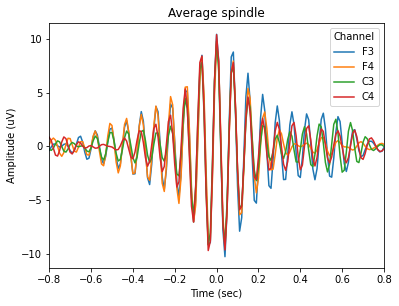

In [21]:
# To speed up the computation, we disable the bootstrap confidence intervals by specifying ci=None.
# For more details, please refer to the documentation of the seaborn.lineplot function at:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
ax = sp.plot_average(center='Peak', time_before=0.8, time_after=0.8, filt=(12, 16), ci=None)

To get the actual peak-locked data underlying this figure, one can use the [get_sync_events](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.get_sync_events) method. The output is a long-format dataframe with the original data values centered around each detected spindles.

In [22]:
df_sync = sp.get_sync_events(center='Peak', time_before=0.8, time_after=0.8)
df_sync

,Time,Event,Amplitude,Channel,IdxChannel
0,-0.80,0,-9.274473,F3,0
1,-0.79,0,-6.832743,F3,0
2,-0.78,0,-4.507523,F3,0
3,-0.77,0,-3.998233,F3,0
4,-0.76,0,-8.483229,F3,0
...,...,...,...,...,...
30907,0.76,49,9.396885,C4,3
30908,0.77,49,6.334050,C4,3
30909,0.78,49,1.008784,C4,3
30910,0.79,49,-0.327676,C4,3


### Calculate the coincidence matrix

Do spindles occur at the same time? One way to measure this is to calculate the coincidence matrix, which gives, for each pair of channel, the number of samples that were marked as a spindle in both channels. The output is a symmetric matrix, in which the diagonal is simply the number of data points that were marked as a spindle in the channel.

In [23]:
sp.get_coincidence_matrix(scaled=False)

Channel,F3,F4,C3,C4
Channel,,,,
F3,3799,997,1386,779
F4,997,4118,1140,1678
C3,1386,1140,4132,1093
C4,779,1678,1093,4356


The coincidence matrix can be scaled (default) by dividing the output by the product of the sum of each individual binary mask. It can then be used to define functional networks or quickly find outlier channels.

In [24]:
coincidence = sp.get_coincidence_matrix()
coincidence

Channel,F3,F4,C3,C4
Channel,,,,
F3,1.000000,0.000064,0.000088,0.000047
F4,0.000064,1.000000,0.000067,0.000094
C3,0.000088,0.000067,1.000000,0.000061
C4,0.000047,0.000094,0.000061,1.000000


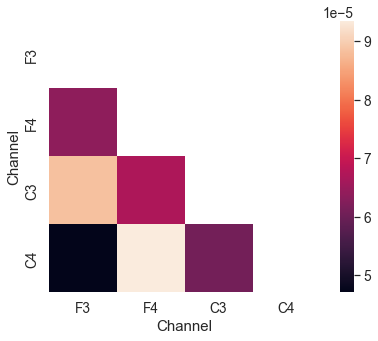

In [25]:
sns.set(style="white", font_scale=1.25)

mask = np.zeros_like(coincidence)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(coincidence, mask=mask, square=True, cmap="rocket")